In [178]:
import scipy.io as sio
import numpy as np
import pandas as pd

# Load the .mat file
mat_data = sio.loadmat('water_dataset.mat')

# Print the keys to see the variables available
print("Keys in the .mat file:", mat_data.keys())

# Extract variables as described in the README
features = mat_data['features']         # list of water indices (1 x 11 array of strings)
location_ids = mat_data['location_ids']   # (37 x 1) array of water station IDs
X_tr = mat_data['X_tr']                   # training set input data: (1 x 423) array, each element is 37x11 matrix
X_te = mat_data['X_te']                   # test set input data: (1 x 282) array, each element is 37x11 matrix
Y_tr = mat_data['Y_tr']                   # training set output data: (37 x 423) matrix
Y_te = mat_data['Y_te']                   # test set output data: (37 x 282) matrix
location_group = mat_data['location_group']  # grouping info for water stations

# Inspect the features array (water indices)
# Depending on how the strings are stored, you may need to decode bytes if necessary.
features_list = [str(feat[0]) for feat in features[0]]
print("Water indices (features):", features_list)

# Flatten location_ids to a 1D array and print
location_ids = location_ids.flatten()
print("Location IDs:", location_ids)

# X_tr and X_te are stored as a 1 x N cell array, where each cell is a 37x11 matrix.
# Let's check their shapes and extract one example.
print("X_tr shape:", X_tr.shape)
print("X_te shape:", X_te.shape)
# Example: Print shape of the first training example (should be 37 x 11)
print("Shape of first training sample:", X_tr[0, 0].shape)

# Convert X_tr and X_te into Python lists for easier handling
X_tr_list = [X_tr[0, i] for i in range(X_tr.shape[1])]
X_te_list = [X_te[0, i] for i in range(X_te.shape[1])]

# Optionally, you can check the number of training and testing days
print("Number of training days:", len(X_tr_list))
print("Number of testing days:", len(X_te_list))

# Y_tr and Y_te are already stored as matrices.
print("Y_tr shape (water quality for training):", Y_tr.shape)  # Expected: (37, 423)
print("Y_te shape (water quality for testing):", Y_te.shape)   # Expected: (37, 282)

# If desired, you can convert Y_tr and Y_te to DataFrames (e.g., each row corresponds to a water station)
Y_tr_df = pd.DataFrame(Y_tr, index=location_ids)
Y_te_df = pd.DataFrame(Y_te, index=location_ids)

print("Training water quality data (first 5 rows):")
print(Y_tr_df.head())

print("Testing water quality data (first 5 rows):")
print(Y_te_df.head())


Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X_tr', 'X_te', 'Y_tr', 'Y_te', 'location_group', 'features', 'location_ids'])
Water indices (features): ['Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Maximum)', 'pH, water, unfiltered, field, standard units (Maximum)', 'pH, water, unfiltered, field, standard units (Minimum)', 'Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Minimum)', 'Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Mean)', 'Dissolved oxygen, water, unfiltered, milligrams per liter (Maximum)', 'Dissolved oxygen, water, unfiltered, milligrams per liter (Mean)', 'Dissolved oxygen, water, unfiltered, milligrams per liter (Minimum)', 'Temperature, water, degrees Celsius (Mean)', 'Temperature, water, degrees Celsius (Minimum)', 'Temperature, water, degrees Celsius (Maximum)']
Location IDs: [  2198840   2198920   

In [179]:
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class WaterQualityDataset(Dataset):
    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file containing the dataset.
            train (bool): If True, load training data; otherwise load test data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the .mat file
        data = scipy.io.loadmat(mat_file)
        self.transform = transform

        # The variable 'location_group' is a 1x3 cell array:
        #   location_group[0,0] => array of stations in group 1
        #   location_group[0,1] => array of stations in group 2
        #   location_group[0,2] => array of stations in group 3
        location_group = data['location_group']  # shape: (1, 3)

        # location_ids might be something like shape: (37, 1) for all station IDs
        location_ids = data['location_ids'].flatten()  # shape: (37,)

        num_stations = len(location_ids)  # should be 37
        # Create an array to store the group ID for each station (1-based or 0-based is up to you)
        group_ids = np.zeros(num_stations, dtype=np.float32)

        # Fill group_ids based on location_group
        for i in range(location_group.shape[1]):
            # Each cell in location_group contains an array of station indices (MATLAB is 1-based)
            station_indices = location_group[0, i].flatten() - 1  # convert to 0-based
            # Assign group number (i+1) to those station indices
            group_ids[station_indices] = i + 1

        # Store group_ids for later usage in __getitem__
        self.group_ids = group_ids

        # Decide whether to load training or testing data
        if train:
            X_data = data['X_tr']  # shape: (1, 423), each cell is 37x11
            Y_data = data['Y_tr']  # shape: (37, 423)
        else:
            X_data = data['X_te']  # shape: (1, 282), each cell is 37x11
            Y_data = data['Y_te']  # shape: (37, 282)

        # Convert cell array into Python lists for easier iteration
        self.X_list = [X_data[0, i] for i in range(X_data.shape[1])]
        self.Y_list = [Y_data[:, i] for i in range(Y_data.shape[1])]

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        # X: shape (37, 11), Y: shape (37,)
        x = self.X_list[idx]
        y = self.Y_list[idx]

        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Build a column vector of group IDs for all 37 stations
        # shape: (37,) => unsqueeze => (37, 1)
        group_col = torch.tensor(self.group_ids, dtype=torch.float32).unsqueeze(1)

        # Concatenate group_col to x along dim=1 => new shape (37, 12)
        x = torch.cat((x, group_col), dim=1)

        # Optionally add a channel dimension for CNN input => shape (1, 37, 12)
        x = x.unsqueeze(0)

        if self.transform:
            x = self.transform(x)

        return x, y

# Example usage:
mat_file_path = 'water_dataset.mat'  # Replace with your .mat file path

# Create dataset instances for training and testing
train_dataset = WaterQualityDataset(mat_file_path, train=True)
test_dataset  = WaterQualityDataset(mat_file_path, train=False)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check one batch to verify the shapes
for batch_x, batch_y in train_loader:
    print("Input batch shape:", batch_x.shape)  # Expected: [batch_size, 1, 37, 12]
    print("Target batch shape:", batch_y.shape) # Expected: [batch_size, 37]
    break



Input batch shape: torch.Size([64, 1, 37, 12])
Target batch shape: torch.Size([64, 37])


In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class WaterQualityCNN(nn.Module):
    def __init__(self):
        super(WaterQualityCNN, self).__init__()
        # Input shape: (batch_size, 1, 37, 12)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)   # -> (batch_size, 16, 37, 12)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # -> (batch_size, 32, 37, 12)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # -> (batch_size, 64, 37, 12)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # -> (batch_size, 128, 37, 12)
        
        # Calculate the flattened dimension after conv4
        self.flatten_dim = 128 * 37 * 12  # 128 channels, 37 rows, 12 columns
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, 256)  # Intermediate fully connected layer
        self.fc2 = nn.Linear(256, 37)                # Final fully connected layer mapping to one prediction per station

    def forward(self, x):
        # x: (batch_size, 1, 37, 12)
        x = F.relu(self.conv1(x))  # -> (batch_size, 16, 37, 12)
        x = F.relu(self.conv2(x))  # -> (batch_size, 32, 37, 12)
        x = F.relu(self.conv3(x))  # -> (batch_size, 64, 37, 12)
        x = F.relu(self.conv4(x))  # -> (batch_size, 128, 37, 12)
        
        # Flatten the feature maps: (batch_size, 128 * 37 * 12)
        x = x.view(x.size(0), -1)
        
        # Pass through fully connected layers with a ReLU activation in between
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # -> (batch_size, 37)
        return x

# Example usage: Create a dummy input and test the forward pass
if __name__ == '__main__':
    model = WaterQualityCNN()
    dummy_input = torch.randn(8, 1, 37, 12)  # batch size of 8
    dummy_output = model(dummy_input)
    print("Dummy output shape:", dummy_output.shape)  # Expected: (8, 37)


Dummy output shape: torch.Size([8, 37])


In [181]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # progress bar

# Assume WaterQualityDataset and WaterQualityCNN have been defined as shown earlier.
# Replace 'water_dataset.mat' with the actual path to your .mat file.
mat_file_path = 'water_dataset.mat'

# Create dataset instances for training and testing
train_dataset = WaterQualityDataset(mat_file_path, train=True)
test_dataset  = WaterQualityDataset(mat_file_path, train=False)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the CNN model, loss function, and optimizer
model = WaterQualityCNN().to(device)
criterion = nn.MSELoss()  # For regression tasks (predicting pH values)
optimizer = optim.Adam(model.parameters(), lr=0.00008)

# Define a learning rate scheduler that reduces lr when test loss has not decreased for 'patience' epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Set the number of epochs
num_epochs = 200

# Training loop with progress printing using tqdm
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Use tqdm to create a progress bar for the training loop
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
    
    for batch_x, batch_y in pbar:
        batch_x = batch_x.to(device)  # shape: [batch_size, 1, 37, 12]
        batch_y = batch_y.to(device)  # shape: [batch_size, 37]
        
        optimizer.zero_grad()  # Reset gradients
        
        # Forward pass
        outputs = model(batch_x)  # Expected output shape: [batch_size, 37]
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_x.size(0)
        
        # Update progress bar with current loss
        pbar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(train_dataset)
    
    # Evaluation phase on the test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
    test_loss /= len(test_dataset)
    
    # Update the learning rate scheduler based on test loss
    scheduler.step(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {epoch_loss:.6f}, Test Loss: {test_loss:.6f}")



C:\Users\75597\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/200 Training: 100%|██████████| 14/14 [00:00<00:00, 68.86it/s, loss=0.0816]


Epoch 1/200 -- Train Loss: 0.263204, Test Loss: 0.071067


Epoch 2/200 Training: 100%|██████████| 14/14 [00:00<00:00, 111.85it/s, loss=0.00868]


Epoch 2/200 -- Train Loss: 0.036137, Test Loss: 0.008328


Epoch 3/200 Training: 100%|██████████| 14/14 [00:00<00:00, 218.54it/s, loss=0.00243]


Epoch 3/200 -- Train Loss: 0.005139, Test Loss: 0.002422


Epoch 4/200 Training: 100%|██████████| 14/14 [00:00<00:00, 218.79it/s, loss=0.000895]


Epoch 4/200 -- Train Loss: 0.001455, Test Loss: 0.000890


Epoch 5/200 Training: 100%|██████████| 14/14 [00:00<00:00, 196.30it/s, loss=0.000496]


Epoch 5/200 -- Train Loss: 0.000681, Test Loss: 0.000620


Epoch 6/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.49it/s, loss=0.000439]


Epoch 6/200 -- Train Loss: 0.000456, Test Loss: 0.000506


Epoch 7/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.84it/s, loss=0.000414]


Epoch 7/200 -- Train Loss: 0.000416, Test Loss: 0.000524


Epoch 8/200 Training: 100%|██████████| 14/14 [00:00<00:00, 198.33it/s, loss=0.000525]


Epoch 8/200 -- Train Loss: 0.000401, Test Loss: 0.000525


Epoch 9/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.51it/s, loss=0.000234]


Epoch 9/200 -- Train Loss: 0.000397, Test Loss: 0.000497


Epoch 10/200 Training: 100%|██████████| 14/14 [00:00<00:00, 199.37it/s, loss=0.000411]


Epoch 10/200 -- Train Loss: 0.000392, Test Loss: 0.000501


Epoch 11/200 Training: 100%|██████████| 14/14 [00:00<00:00, 194.04it/s, loss=0.000425]


Epoch 11/200 -- Train Loss: 0.000390, Test Loss: 0.000507


Epoch 12/200 Training: 100%|██████████| 14/14 [00:00<00:00, 211.70it/s, loss=0.00037]


Epoch 12/200 -- Train Loss: 0.000389, Test Loss: 0.000512


Epoch 13/200 Training: 100%|██████████| 14/14 [00:00<00:00, 206.36it/s, loss=0.000415]


Epoch 13/200 -- Train Loss: 0.000388, Test Loss: 0.000505


Epoch 14/200 Training: 100%|██████████| 14/14 [00:00<00:00, 191.36it/s, loss=0.000341]


Epoch 14/200 -- Train Loss: 0.000386, Test Loss: 0.000485


Epoch 15/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.61it/s, loss=0.000345]


Epoch 15/200 -- Train Loss: 0.000383, Test Loss: 0.000500


Epoch 16/200 Training: 100%|██████████| 14/14 [00:00<00:00, 206.83it/s, loss=0.000485]


Epoch 16/200 -- Train Loss: 0.000377, Test Loss: 0.000496


Epoch 17/200 Training: 100%|██████████| 14/14 [00:00<00:00, 201.40it/s, loss=0.000512]


Epoch 17/200 -- Train Loss: 0.000375, Test Loss: 0.000496


Epoch 18/200 Training: 100%|██████████| 14/14 [00:00<00:00, 212.55it/s, loss=0.000225]


Epoch 18/200 -- Train Loss: 0.000378, Test Loss: 0.000515


Epoch 19/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.52it/s, loss=0.000385]


Epoch 19/200 -- Train Loss: 0.000377, Test Loss: 0.000512


Epoch 20/200 Training: 100%|██████████| 14/14 [00:00<00:00, 199.46it/s, loss=0.000651]


Epoch 20/200 -- Train Loss: 0.000372, Test Loss: 0.000512


Epoch 21/200 Training: 100%|██████████| 14/14 [00:00<00:00, 207.00it/s, loss=0.000263]


Epoch 21/200 -- Train Loss: 0.000362, Test Loss: 0.000497


Epoch 22/200 Training: 100%|██████████| 14/14 [00:00<00:00, 204.43it/s, loss=0.000256]


Epoch 22/200 -- Train Loss: 0.000360, Test Loss: 0.000505


Epoch 23/200 Training: 100%|██████████| 14/14 [00:00<00:00, 217.37it/s, loss=0.000301]


Epoch 23/200 -- Train Loss: 0.000355, Test Loss: 0.000491


Epoch 24/200 Training: 100%|██████████| 14/14 [00:00<00:00, 206.13it/s, loss=0.000572]


Epoch 24/200 -- Train Loss: 0.000351, Test Loss: 0.000522


Epoch 25/200 Training: 100%|██████████| 14/14 [00:00<00:00, 211.74it/s, loss=0.000687]


Epoch 25/200 -- Train Loss: 0.000353, Test Loss: 0.000489


Epoch 26/200 Training: 100%|██████████| 14/14 [00:00<00:00, 194.64it/s, loss=0.000297]


Epoch 26/200 -- Train Loss: 0.000346, Test Loss: 0.000492


Epoch 27/200 Training: 100%|██████████| 14/14 [00:00<00:00, 212.79it/s, loss=0.000314]


Epoch 27/200 -- Train Loss: 0.000344, Test Loss: 0.000490


Epoch 28/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.63it/s, loss=0.000332]


Epoch 28/200 -- Train Loss: 0.000344, Test Loss: 0.000500


Epoch 29/200 Training: 100%|██████████| 14/14 [00:00<00:00, 199.59it/s, loss=0.000602]


Epoch 29/200 -- Train Loss: 0.000340, Test Loss: 0.000489


Epoch 30/200 Training: 100%|██████████| 14/14 [00:00<00:00, 227.46it/s, loss=0.000289]


Epoch 30/200 -- Train Loss: 0.000339, Test Loss: 0.000493


Epoch 31/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.85it/s, loss=0.000267]


Epoch 31/200 -- Train Loss: 0.000337, Test Loss: 0.000488


Epoch 32/200 Training: 100%|██████████| 14/14 [00:00<00:00, 200.97it/s, loss=0.000302]


Epoch 32/200 -- Train Loss: 0.000335, Test Loss: 0.000490


Epoch 33/200 Training: 100%|██████████| 14/14 [00:00<00:00, 205.19it/s, loss=0.000453]


Epoch 33/200 -- Train Loss: 0.000335, Test Loss: 0.000483


Epoch 34/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.28it/s, loss=0.000202]


Epoch 34/200 -- Train Loss: 0.000331, Test Loss: 0.000487


Epoch 35/200 Training: 100%|██████████| 14/14 [00:00<00:00, 203.99it/s, loss=0.000595]


Epoch 35/200 -- Train Loss: 0.000330, Test Loss: 0.000492


Epoch 36/200 Training: 100%|██████████| 14/14 [00:00<00:00, 220.26it/s, loss=0.00058]


Epoch 36/200 -- Train Loss: 0.000336, Test Loss: 0.000483


Epoch 37/200 Training: 100%|██████████| 14/14 [00:00<00:00, 206.68it/s, loss=0.000206]


Epoch 37/200 -- Train Loss: 0.000330, Test Loss: 0.000491


Epoch 38/200 Training: 100%|██████████| 14/14 [00:00<00:00, 205.47it/s, loss=0.000352]


Epoch 38/200 -- Train Loss: 0.000330, Test Loss: 0.000484


Epoch 39/200 Training: 100%|██████████| 14/14 [00:00<00:00, 201.99it/s, loss=0.000235]


Epoch 39/200 -- Train Loss: 0.000326, Test Loss: 0.000487


Epoch 40/200 Training: 100%|██████████| 14/14 [00:00<00:00, 214.97it/s, loss=0.000504]


Epoch 40/200 -- Train Loss: 0.000332, Test Loss: 0.000523


Epoch 41/200 Training: 100%|██████████| 14/14 [00:00<00:00, 196.98it/s, loss=0.00025]


Epoch 41/200 -- Train Loss: 0.000330, Test Loss: 0.000509


Epoch 42/200 Training: 100%|██████████| 14/14 [00:00<00:00, 220.24it/s, loss=0.00036]


Epoch 42/200 -- Train Loss: 0.000326, Test Loss: 0.000488


Epoch 43/200 Training: 100%|██████████| 14/14 [00:00<00:00, 208.72it/s, loss=0.000323]


Epoch 43/200 -- Train Loss: 0.000321, Test Loss: 0.000502


Epoch 44/200 Training: 100%|██████████| 14/14 [00:00<00:00, 185.08it/s, loss=0.000301]


Epoch 44/200 -- Train Loss: 0.000320, Test Loss: 0.000488


Epoch 45/200 Training: 100%|██████████| 14/14 [00:00<00:00, 204.03it/s, loss=0.000204]


Epoch 45/200 -- Train Loss: 0.000317, Test Loss: 0.000498


Epoch 46/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.50it/s, loss=0.00043]


Epoch 46/200 -- Train Loss: 0.000317, Test Loss: 0.000483


Epoch 47/200 Training: 100%|██████████| 14/14 [00:00<00:00, 196.94it/s, loss=0.000476]


Epoch 47/200 -- Train Loss: 0.000314, Test Loss: 0.000490


Epoch 48/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.83it/s, loss=0.000232]


Epoch 48/200 -- Train Loss: 0.000316, Test Loss: 0.000498


Epoch 49/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.48it/s, loss=0.000577]


Epoch 49/200 -- Train Loss: 0.000312, Test Loss: 0.000496


Epoch 50/200 Training: 100%|██████████| 14/14 [00:00<00:00, 205.65it/s, loss=0.000222]


Epoch 50/200 -- Train Loss: 0.000313, Test Loss: 0.000486


Epoch 51/200 Training: 100%|██████████| 14/14 [00:00<00:00, 208.55it/s, loss=0.00032]


Epoch 51/200 -- Train Loss: 0.000310, Test Loss: 0.000487


Epoch 52/200 Training: 100%|██████████| 14/14 [00:00<00:00, 211.72it/s, loss=0.000301]


Epoch 52/200 -- Train Loss: 0.000308, Test Loss: 0.000480


Epoch 53/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.85it/s, loss=0.00045]


Epoch 53/200 -- Train Loss: 0.000307, Test Loss: 0.000476


Epoch 54/200 Training: 100%|██████████| 14/14 [00:00<00:00, 199.66it/s, loss=0.000436]


Epoch 54/200 -- Train Loss: 0.000306, Test Loss: 0.000475


Epoch 55/200 Training: 100%|██████████| 14/14 [00:00<00:00, 223.76it/s, loss=0.000262]


Epoch 55/200 -- Train Loss: 0.000301, Test Loss: 0.000474


Epoch 56/200 Training: 100%|██████████| 14/14 [00:00<00:00, 212.74it/s, loss=0.000198]


Epoch 56/200 -- Train Loss: 0.000300, Test Loss: 0.000480


Epoch 57/200 Training: 100%|██████████| 14/14 [00:00<00:00, 186.54it/s, loss=0.00065]


Epoch 57/200 -- Train Loss: 0.000298, Test Loss: 0.000480


Epoch 58/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.10it/s, loss=0.0004]


Epoch 58/200 -- Train Loss: 0.000301, Test Loss: 0.000505


Epoch 59/200 Training: 100%|██████████| 14/14 [00:00<00:00, 222.01it/s, loss=0.000258]


Epoch 59/200 -- Train Loss: 0.000299, Test Loss: 0.000482


Epoch 60/200 Training: 100%|██████████| 14/14 [00:00<00:00, 192.27it/s, loss=0.000262]


Epoch 60/200 -- Train Loss: 0.000295, Test Loss: 0.000486


Epoch 61/200 Training: 100%|██████████| 14/14 [00:00<00:00, 223.73it/s, loss=0.000284]


Epoch 61/200 -- Train Loss: 0.000291, Test Loss: 0.000481


Epoch 62/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.72it/s, loss=0.000188]


Epoch 62/200 -- Train Loss: 0.000289, Test Loss: 0.000483


Epoch 63/200 Training: 100%|██████████| 14/14 [00:00<00:00, 191.95it/s, loss=0.000272]


Epoch 63/200 -- Train Loss: 0.000287, Test Loss: 0.000486


Epoch 64/200 Training: 100%|██████████| 14/14 [00:00<00:00, 217.58it/s, loss=0.000302]


Epoch 64/200 -- Train Loss: 0.000286, Test Loss: 0.000477


Epoch 65/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.94it/s, loss=0.000327]


Epoch 65/200 -- Train Loss: 0.000283, Test Loss: 0.000473


Epoch 66/200 Training: 100%|██████████| 14/14 [00:00<00:00, 198.36it/s, loss=0.000182]


Epoch 66/200 -- Train Loss: 0.000292, Test Loss: 0.000486


Epoch 67/200 Training: 100%|██████████| 14/14 [00:00<00:00, 218.56it/s, loss=0.000259]


Epoch 67/200 -- Train Loss: 0.000287, Test Loss: 0.000474


Epoch 68/200 Training: 100%|██████████| 14/14 [00:00<00:00, 211.48it/s, loss=0.000296]


Epoch 68/200 -- Train Loss: 0.000283, Test Loss: 0.000481


Epoch 69/200 Training: 100%|██████████| 14/14 [00:00<00:00, 186.74it/s, loss=0.000249]


Epoch 69/200 -- Train Loss: 0.000276, Test Loss: 0.000477


Epoch 70/200 Training: 100%|██████████| 14/14 [00:00<00:00, 219.82it/s, loss=0.000255]


Epoch 70/200 -- Train Loss: 0.000274, Test Loss: 0.000459


Epoch 71/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.49it/s, loss=0.000257]


Epoch 71/200 -- Train Loss: 0.000274, Test Loss: 0.000464


Epoch 72/200 Training: 100%|██████████| 14/14 [00:00<00:00, 199.21it/s, loss=0.000504]


Epoch 72/200 -- Train Loss: 0.000272, Test Loss: 0.000465


Epoch 73/200 Training: 100%|██████████| 14/14 [00:00<00:00, 222.50it/s, loss=0.00039]


Epoch 73/200 -- Train Loss: 0.000272, Test Loss: 0.000477


Epoch 74/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.79it/s, loss=0.000351]


Epoch 74/200 -- Train Loss: 0.000269, Test Loss: 0.000471


Epoch 75/200 Training: 100%|██████████| 14/14 [00:00<00:00, 186.32it/s, loss=0.000225]


Epoch 75/200 -- Train Loss: 0.000268, Test Loss: 0.000465


Epoch 76/200 Training: 100%|██████████| 14/14 [00:00<00:00, 209.88it/s, loss=0.000192]


Epoch 76/200 -- Train Loss: 0.000263, Test Loss: 0.000472


Epoch 77/200 Training: 100%|██████████| 14/14 [00:00<00:00, 208.59it/s, loss=0.000242]


Epoch 77/200 -- Train Loss: 0.000263, Test Loss: 0.000479


Epoch 78/200 Training: 100%|██████████| 14/14 [00:00<00:00, 195.30it/s, loss=0.000235]


Epoch 78/200 -- Train Loss: 0.000262, Test Loss: 0.000471


Epoch 79/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.33it/s, loss=0.000289]


Epoch 79/200 -- Train Loss: 0.000259, Test Loss: 0.000461


Epoch 80/200 Training: 100%|██████████| 14/14 [00:00<00:00, 206.58it/s, loss=0.000205]


Epoch 80/200 -- Train Loss: 0.000256, Test Loss: 0.000462


Epoch 81/200 Training: 100%|██████████| 14/14 [00:00<00:00, 190.07it/s, loss=0.00023]


Epoch 81/200 -- Train Loss: 0.000254, Test Loss: 0.000468


Epoch 82/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.80it/s, loss=0.000183]


Epoch 82/200 -- Train Loss: 0.000252, Test Loss: 0.000450


Epoch 83/200 Training: 100%|██████████| 14/14 [00:00<00:00, 212.29it/s, loss=0.000283]


Epoch 83/200 -- Train Loss: 0.000251, Test Loss: 0.000454


Epoch 84/200 Training: 100%|██████████| 14/14 [00:00<00:00, 201.20it/s, loss=0.000311]


Epoch 84/200 -- Train Loss: 0.000254, Test Loss: 0.000447


Epoch 85/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.17it/s, loss=0.000229]


Epoch 85/200 -- Train Loss: 0.000248, Test Loss: 0.000456


Epoch 86/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.51it/s, loss=0.000251]


Epoch 86/200 -- Train Loss: 0.000249, Test Loss: 0.000461


Epoch 87/200 Training: 100%|██████████| 14/14 [00:00<00:00, 190.50it/s, loss=0.000365]


Epoch 87/200 -- Train Loss: 0.000245, Test Loss: 0.000450


Epoch 88/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.32it/s, loss=0.000245]


Epoch 88/200 -- Train Loss: 0.000244, Test Loss: 0.000454


Epoch 89/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.02it/s, loss=0.000159]


Epoch 89/200 -- Train Loss: 0.000245, Test Loss: 0.000456


Epoch 90/200 Training: 100%|██████████| 14/14 [00:00<00:00, 192.84it/s, loss=0.00018]


Epoch 90/200 -- Train Loss: 0.000244, Test Loss: 0.000458


Epoch 91/200 Training: 100%|██████████| 14/14 [00:00<00:00, 218.51it/s, loss=0.000181]


Epoch 91/200 -- Train Loss: 0.000243, Test Loss: 0.000454


Epoch 92/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.28it/s, loss=0.000126]


Epoch 92/200 -- Train Loss: 0.000241, Test Loss: 0.000454


Epoch 93/200 Training: 100%|██████████| 14/14 [00:00<00:00, 188.92it/s, loss=0.000285]


Epoch 93/200 -- Train Loss: 0.000240, Test Loss: 0.000450


Epoch 94/200 Training: 100%|██████████| 14/14 [00:00<00:00, 208.42it/s, loss=0.000275]


Epoch 94/200 -- Train Loss: 0.000242, Test Loss: 0.000462


Epoch 95/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.51it/s, loss=0.000188]


Epoch 95/200 -- Train Loss: 0.000240, Test Loss: 0.000451


Epoch 96/200 Training: 100%|██████████| 14/14 [00:00<00:00, 193.23it/s, loss=0.000217]


Epoch 96/200 -- Train Loss: 0.000238, Test Loss: 0.000451


Epoch 97/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.81it/s, loss=0.000389]


Epoch 97/200 -- Train Loss: 0.000238, Test Loss: 0.000449


Epoch 98/200 Training: 100%|██████████| 14/14 [00:00<00:00, 221.97it/s, loss=0.000258]


Epoch 98/200 -- Train Loss: 0.000237, Test Loss: 0.000453


Epoch 99/200 Training: 100%|██████████| 14/14 [00:00<00:00, 192.70it/s, loss=0.000175]


Epoch 99/200 -- Train Loss: 0.000236, Test Loss: 0.000447


Epoch 100/200 Training: 100%|██████████| 14/14 [00:00<00:00, 218.31it/s, loss=0.000262]


Epoch 100/200 -- Train Loss: 0.000235, Test Loss: 0.000452


Epoch 101/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.75it/s, loss=0.000252]


Epoch 101/200 -- Train Loss: 0.000235, Test Loss: 0.000449


Epoch 102/200 Training: 100%|██████████| 14/14 [00:00<00:00, 193.80it/s, loss=0.000192]


Epoch 102/200 -- Train Loss: 0.000235, Test Loss: 0.000455


Epoch 103/200 Training: 100%|██████████| 14/14 [00:00<00:00, 223.61it/s, loss=0.000252]


Epoch 103/200 -- Train Loss: 0.000235, Test Loss: 0.000446


Epoch 104/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.53it/s, loss=0.000232]


Epoch 104/200 -- Train Loss: 0.000234, Test Loss: 0.000451


Epoch 105/200 Training: 100%|██████████| 14/14 [00:00<00:00, 190.70it/s, loss=0.000344]


Epoch 105/200 -- Train Loss: 0.000233, Test Loss: 0.000447


Epoch 106/200 Training: 100%|██████████| 14/14 [00:00<00:00, 200.59it/s, loss=0.000229]


Epoch 106/200 -- Train Loss: 0.000234, Test Loss: 0.000451


Epoch 107/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.14it/s, loss=0.000176]


Epoch 107/200 -- Train Loss: 0.000232, Test Loss: 0.000452


Epoch 108/200 Training: 100%|██████████| 14/14 [00:00<00:00, 199.76it/s, loss=0.000182]


Epoch 108/200 -- Train Loss: 0.000233, Test Loss: 0.000445


Epoch 109/200 Training: 100%|██████████| 14/14 [00:00<00:00, 200.76it/s, loss=0.00018]


Epoch 109/200 -- Train Loss: 0.000231, Test Loss: 0.000451


Epoch 110/200 Training: 100%|██████████| 14/14 [00:00<00:00, 217.89it/s, loss=0.000237]


Epoch 110/200 -- Train Loss: 0.000231, Test Loss: 0.000449


Epoch 111/200 Training: 100%|██████████| 14/14 [00:00<00:00, 190.18it/s, loss=0.000462]


Epoch 111/200 -- Train Loss: 0.000231, Test Loss: 0.000452


Epoch 112/200 Training: 100%|██████████| 14/14 [00:00<00:00, 208.05it/s, loss=0.00032]


Epoch 112/200 -- Train Loss: 0.000231, Test Loss: 0.000447


Epoch 113/200 Training: 100%|██████████| 14/14 [00:00<00:00, 219.58it/s, loss=0.000286]


Epoch 113/200 -- Train Loss: 0.000231, Test Loss: 0.000444


Epoch 114/200 Training: 100%|██████████| 14/14 [00:00<00:00, 222.87it/s, loss=0.000279]


Epoch 114/200 -- Train Loss: 0.000230, Test Loss: 0.000450


Epoch 115/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.17it/s, loss=0.000249]


Epoch 115/200 -- Train Loss: 0.000230, Test Loss: 0.000446


Epoch 116/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.30it/s, loss=0.000288]


Epoch 116/200 -- Train Loss: 0.000230, Test Loss: 0.000448


Epoch 117/200 Training: 100%|██████████| 14/14 [00:00<00:00, 196.90it/s, loss=0.000144]


Epoch 117/200 -- Train Loss: 0.000229, Test Loss: 0.000443


Epoch 118/200 Training: 100%|██████████| 14/14 [00:00<00:00, 211.84it/s, loss=0.000202]


Epoch 118/200 -- Train Loss: 0.000229, Test Loss: 0.000449


Epoch 119/200 Training: 100%|██████████| 14/14 [00:00<00:00, 214.09it/s, loss=0.000208]


Epoch 119/200 -- Train Loss: 0.000229, Test Loss: 0.000441


Epoch 120/200 Training: 100%|██████████| 14/14 [00:00<00:00, 205.68it/s, loss=0.000224]


Epoch 120/200 -- Train Loss: 0.000227, Test Loss: 0.000444


Epoch 121/200 Training: 100%|██████████| 14/14 [00:00<00:00, 212.67it/s, loss=0.000164]


Epoch 121/200 -- Train Loss: 0.000227, Test Loss: 0.000440


Epoch 122/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.55it/s, loss=0.000194]


Epoch 122/200 -- Train Loss: 0.000227, Test Loss: 0.000444


Epoch 123/200 Training: 100%|██████████| 14/14 [00:00<00:00, 192.68it/s, loss=0.000259]


Epoch 123/200 -- Train Loss: 0.000228, Test Loss: 0.000449


Epoch 124/200 Training: 100%|██████████| 14/14 [00:00<00:00, 205.35it/s, loss=0.000315]


Epoch 124/200 -- Train Loss: 0.000227, Test Loss: 0.000437


Epoch 125/200 Training: 100%|██████████| 14/14 [00:00<00:00, 209.06it/s, loss=0.000451]


Epoch 125/200 -- Train Loss: 0.000226, Test Loss: 0.000444


Epoch 126/200 Training: 100%|██████████| 14/14 [00:00<00:00, 199.21it/s, loss=0.000423]


Epoch 126/200 -- Train Loss: 0.000226, Test Loss: 0.000443


Epoch 127/200 Training: 100%|██████████| 14/14 [00:00<00:00, 223.62it/s, loss=0.000143]


Epoch 127/200 -- Train Loss: 0.000225, Test Loss: 0.000452


Epoch 128/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.14it/s, loss=0.000273]


Epoch 128/200 -- Train Loss: 0.000225, Test Loss: 0.000444


Epoch 129/200 Training: 100%|██████████| 14/14 [00:00<00:00, 186.41it/s, loss=0.000113]


Epoch 129/200 -- Train Loss: 0.000225, Test Loss: 0.000438


Epoch 130/200 Training: 100%|██████████| 14/14 [00:00<00:00, 220.25it/s, loss=0.000186]


Epoch 130/200 -- Train Loss: 0.000225, Test Loss: 0.000447


Epoch 131/200 Training: 100%|██████████| 14/14 [00:00<00:00, 208.45it/s, loss=0.000196]


Epoch 131/200 -- Train Loss: 0.000224, Test Loss: 0.000441


Epoch 132/200 Training: 100%|██████████| 14/14 [00:00<00:00, 198.35it/s, loss=0.000146]


Epoch 132/200 -- Train Loss: 0.000224, Test Loss: 0.000443


Epoch 133/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.44it/s, loss=0.000298]


Epoch 133/200 -- Train Loss: 0.000223, Test Loss: 0.000449


Epoch 134/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.27it/s, loss=0.000159]


Epoch 134/200 -- Train Loss: 0.000223, Test Loss: 0.000440


Epoch 135/200 Training: 100%|██████████| 14/14 [00:00<00:00, 189.89it/s, loss=0.000207]


Epoch 135/200 -- Train Loss: 0.000222, Test Loss: 0.000443


Epoch 136/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.28it/s, loss=0.000189]


Epoch 136/200 -- Train Loss: 0.000222, Test Loss: 0.000439


Epoch 137/200 Training: 100%|██████████| 14/14 [00:00<00:00, 206.44it/s, loss=0.0002]


Epoch 137/200 -- Train Loss: 0.000221, Test Loss: 0.000443


Epoch 138/200 Training: 100%|██████████| 14/14 [00:00<00:00, 194.23it/s, loss=0.000271]


Epoch 138/200 -- Train Loss: 0.000221, Test Loss: 0.000439


Epoch 139/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.18it/s, loss=0.000237]


Epoch 139/200 -- Train Loss: 0.000221, Test Loss: 0.000440


Epoch 140/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.83it/s, loss=0.000248]


Epoch 140/200 -- Train Loss: 0.000221, Test Loss: 0.000443


Epoch 141/200 Training: 100%|██████████| 14/14 [00:00<00:00, 195.51it/s, loss=0.000154]


Epoch 141/200 -- Train Loss: 0.000220, Test Loss: 0.000439


Epoch 142/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.31it/s, loss=0.000198]


Epoch 142/200 -- Train Loss: 0.000220, Test Loss: 0.000441


Epoch 143/200 Training: 100%|██████████| 14/14 [00:00<00:00, 206.17it/s, loss=0.000182]


Epoch 143/200 -- Train Loss: 0.000219, Test Loss: 0.000440


Epoch 144/200 Training: 100%|██████████| 14/14 [00:00<00:00, 198.32it/s, loss=0.000224]


Epoch 144/200 -- Train Loss: 0.000219, Test Loss: 0.000440


Epoch 145/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.24it/s, loss=0.000222]


Epoch 145/200 -- Train Loss: 0.000219, Test Loss: 0.000440


Epoch 146/200 Training: 100%|██████████| 14/14 [00:00<00:00, 202.64it/s, loss=0.000195]


Epoch 146/200 -- Train Loss: 0.000219, Test Loss: 0.000439


Epoch 147/200 Training: 100%|██████████| 14/14 [00:00<00:00, 182.33it/s, loss=0.000194]

Epoch 147/200 -- Train Loss: 0.000219, Test Loss: 0.000440

Epoch 148/200 Training: 100%|██████████| 14/14 [00:00<00:00, 199.77it/s, loss=0.000163]


Epoch 148/200 -- Train Loss: 0.000218, Test Loss: 0.000440


Epoch 149/200 Training: 100%|██████████| 14/14 [00:00<00:00, 209.46it/s, loss=0.000197]


Epoch 149/200 -- Train Loss: 0.000218, Test Loss: 0.000439


Epoch 150/200 Training: 100%|██████████| 14/14 [00:00<00:00, 191.78it/s, loss=0.000222]


Epoch 150/200 -- Train Loss: 0.000218, Test Loss: 0.000441


Epoch 151/200 Training: 100%|██████████| 14/14 [00:00<00:00, 218.43it/s, loss=0.00013]


Epoch 151/200 -- Train Loss: 0.000218, Test Loss: 0.000438


Epoch 152/200 Training: 100%|██████████| 14/14 [00:00<00:00, 212.74it/s, loss=0.000289]


Epoch 152/200 -- Train Loss: 0.000218, Test Loss: 0.000439


Epoch 153/200 Training: 100%|██████████| 14/14 [00:00<00:00, 180.84it/s, loss=0.000115]


Epoch 153/200 -- Train Loss: 0.000218, Test Loss: 0.000438


Epoch 154/200 Training: 100%|██████████| 14/14 [00:00<00:00, 205.63it/s, loss=0.000198]


Epoch 154/200 -- Train Loss: 0.000218, Test Loss: 0.000440


Epoch 155/200 Training: 100%|██████████| 14/14 [00:00<00:00, 202.19it/s, loss=0.000144]


Epoch 155/200 -- Train Loss: 0.000218, Test Loss: 0.000435


Epoch 156/200 Training: 100%|██████████| 14/14 [00:00<00:00, 188.15it/s, loss=0.000274]


Epoch 156/200 -- Train Loss: 0.000218, Test Loss: 0.000438


Epoch 157/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.48it/s, loss=0.000158]


Epoch 157/200 -- Train Loss: 0.000218, Test Loss: 0.000439


Epoch 158/200 Training: 100%|██████████| 14/14 [00:00<00:00, 214.88it/s, loss=0.000258]


Epoch 158/200 -- Train Loss: 0.000218, Test Loss: 0.000439


Epoch 159/200 Training: 100%|██████████| 14/14 [00:00<00:00, 194.43it/s, loss=0.000172]


Epoch 159/200 -- Train Loss: 0.000217, Test Loss: 0.000439


Epoch 160/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.50it/s, loss=0.000272]


Epoch 160/200 -- Train Loss: 0.000217, Test Loss: 0.000438


Epoch 161/200 Training: 100%|██████████| 14/14 [00:00<00:00, 214.35it/s, loss=0.000168]


Epoch 161/200 -- Train Loss: 0.000217, Test Loss: 0.000439


Epoch 162/200 Training: 100%|██████████| 14/14 [00:00<00:00, 196.78it/s, loss=0.000158]


Epoch 162/200 -- Train Loss: 0.000217, Test Loss: 0.000438


Epoch 163/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.54it/s, loss=0.000232]


Epoch 163/200 -- Train Loss: 0.000217, Test Loss: 0.000439


Epoch 164/200 Training: 100%|██████████| 14/14 [00:00<00:00, 211.90it/s, loss=0.0002]


Epoch 164/200 -- Train Loss: 0.000217, Test Loss: 0.000438


Epoch 165/200 Training: 100%|██████████| 14/14 [00:00<00:00, 189.68it/s, loss=0.000209]


Epoch 165/200 -- Train Loss: 0.000217, Test Loss: 0.000437


Epoch 166/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.18it/s, loss=0.000172]


Epoch 166/200 -- Train Loss: 0.000217, Test Loss: 0.000440


Epoch 167/200 Training: 100%|██████████| 14/14 [00:00<00:00, 204.08it/s, loss=0.000383]


Epoch 167/200 -- Train Loss: 0.000216, Test Loss: 0.000439


Epoch 168/200 Training: 100%|██████████| 14/14 [00:00<00:00, 190.78it/s, loss=0.000143]


Epoch 168/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 169/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.51it/s, loss=0.000203]


Epoch 169/200 -- Train Loss: 0.000216, Test Loss: 0.000438


Epoch 170/200 Training: 100%|██████████| 14/14 [00:00<00:00, 211.92it/s, loss=0.000184]


Epoch 170/200 -- Train Loss: 0.000217, Test Loss: 0.000436


Epoch 171/200 Training: 100%|██████████| 14/14 [00:00<00:00, 182.71it/s, loss=0.000209]


Epoch 171/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 172/200 Training: 100%|██████████| 14/14 [00:00<00:00, 207.17it/s, loss=0.000169]


Epoch 172/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 173/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.26it/s, loss=0.000134]


Epoch 173/200 -- Train Loss: 0.000216, Test Loss: 0.000436


Epoch 174/200 Training: 100%|██████████| 14/14 [00:00<00:00, 191.86it/s, loss=0.000171]


Epoch 174/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 175/200 Training: 100%|██████████| 14/14 [00:00<00:00, 216.87it/s, loss=0.000339]


Epoch 175/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 176/200 Training: 100%|██████████| 14/14 [00:00<00:00, 209.10it/s, loss=0.000157]


Epoch 176/200 -- Train Loss: 0.000216, Test Loss: 0.000438


Epoch 177/200 Training: 100%|██████████| 14/14 [00:00<00:00, 191.46it/s, loss=0.000114]


Epoch 177/200 -- Train Loss: 0.000216, Test Loss: 0.000438


Epoch 178/200 Training: 100%|██████████| 14/14 [00:00<00:00, 207.01it/s, loss=0.000184]


Epoch 178/200 -- Train Loss: 0.000216, Test Loss: 0.000438


Epoch 179/200 Training: 100%|██████████| 14/14 [00:00<00:00, 208.75it/s, loss=0.000192]


Epoch 179/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 180/200 Training: 100%|██████████| 14/14 [00:00<00:00, 190.67it/s, loss=0.00017]


Epoch 180/200 -- Train Loss: 0.000216, Test Loss: 0.000438


Epoch 181/200 Training: 100%|██████████| 14/14 [00:00<00:00, 190.76it/s, loss=0.000138]


Epoch 181/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 182/200 Training: 100%|██████████| 14/14 [00:00<00:00, 205.16it/s, loss=0.00019]


Epoch 182/200 -- Train Loss: 0.000216, Test Loss: 0.000436


Epoch 183/200 Training: 100%|██████████| 14/14 [00:00<00:00, 190.14it/s, loss=0.000241]


Epoch 183/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 184/200 Training: 100%|██████████| 14/14 [00:00<00:00, 203.96it/s, loss=0.000248]


Epoch 184/200 -- Train Loss: 0.000216, Test Loss: 0.000438


Epoch 185/200 Training: 100%|██████████| 14/14 [00:00<00:00, 208.68it/s, loss=0.000163]


Epoch 185/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 186/200 Training: 100%|██████████| 14/14 [00:00<00:00, 187.02it/s, loss=0.000261]


Epoch 186/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 187/200 Training: 100%|██████████| 14/14 [00:00<00:00, 213.50it/s, loss=0.000198]


Epoch 187/200 -- Train Loss: 0.000216, Test Loss: 0.000438


Epoch 188/200 Training: 100%|██████████| 14/14 [00:00<00:00, 200.31it/s, loss=0.000244]


Epoch 188/200 -- Train Loss: 0.000216, Test Loss: 0.000435


Epoch 189/200 Training: 100%|██████████| 14/14 [00:00<00:00, 194.17it/s, loss=0.000233]


Epoch 189/200 -- Train Loss: 0.000216, Test Loss: 0.000437


Epoch 190/200 Training: 100%|██████████| 14/14 [00:00<00:00, 211.88it/s, loss=0.00016]


Epoch 190/200 -- Train Loss: 0.000215, Test Loss: 0.000438


Epoch 191/200 Training: 100%|██████████| 14/14 [00:00<00:00, 203.04it/s, loss=0.000236]


Epoch 191/200 -- Train Loss: 0.000216, Test Loss: 0.000438


Epoch 192/200 Training: 100%|██████████| 14/14 [00:00<00:00, 201.83it/s, loss=0.000219]


Epoch 192/200 -- Train Loss: 0.000216, Test Loss: 0.000436


Epoch 193/200 Training: 100%|██████████| 14/14 [00:00<00:00, 209.02it/s, loss=0.000248]


Epoch 193/200 -- Train Loss: 0.000215, Test Loss: 0.000437


Epoch 194/200 Training: 100%|██████████| 14/14 [00:00<00:00, 215.90it/s, loss=0.000219]


Epoch 194/200 -- Train Loss: 0.000215, Test Loss: 0.000437


Epoch 195/200 Training: 100%|██████████| 14/14 [00:00<00:00, 202.52it/s, loss=0.000213]


Epoch 195/200 -- Train Loss: 0.000215, Test Loss: 0.000437


Epoch 196/200 Training: 100%|██████████| 14/14 [00:00<00:00, 200.67it/s, loss=0.000133]


Epoch 196/200 -- Train Loss: 0.000215, Test Loss: 0.000437


Epoch 197/200 Training: 100%|██████████| 14/14 [00:00<00:00, 210.29it/s, loss=0.000232]


Epoch 197/200 -- Train Loss: 0.000215, Test Loss: 0.000436


Epoch 198/200 Training: 100%|██████████| 14/14 [00:00<00:00, 186.62it/s, loss=0.000221]


Epoch 198/200 -- Train Loss: 0.000215, Test Loss: 0.000438


Epoch 199/200 Training: 100%|██████████| 14/14 [00:00<00:00, 200.24it/s, loss=0.000204]


Epoch 199/200 -- Train Loss: 0.000215, Test Loss: 0.000439


Epoch 200/200 Training: 100%|██████████| 14/14 [00:00<00:00, 223.77it/s, loss=0.000206]


Epoch 200/200 -- Train Loss: 0.000215, Test Loss: 0.000438


Comparison for the first sample in the batch:
Station  1: True = 0.6574, Predicted = 0.6503
Station  2: True = 0.6389, Predicted = 0.6459
Station  3: True = 0.6389, Predicted = 0.6448
Station  4: True = 0.6574, Predicted = 0.6561
Station  5: True = 0.6759, Predicted = 0.6602
Station  6: True = 0.6389, Predicted = 0.6316
Station  7: True = 0.6481, Predicted = 0.6456
Station  8: True = 0.6667, Predicted = 0.6708
Station  9: True = 0.6759, Predicted = 0.6944
Station 10: True = 0.6667, Predicted = 0.6437
Station 11: True = 0.6389, Predicted = 0.6470
Station 12: True = 0.6574, Predicted = 0.6502
Station 13: True = 0.6574, Predicted = 0.6556
Station 14: True = 0.6389, Predicted = 0.6317
Station 15: True = 0.6296, Predicted = 0.6301
Station 16: True = 0.6481, Predicted = 0.6584
Station 17: True = 0.6019, Predicted = 0.6403
Station 18: True = 0.6204, Predicted = 0.6748
Station 19: True = 0.6204, Predicted = 0.6641
Station 20: True = 0.6389, Predicted = 0.6368
Station 21: True = 0.6574, Predict

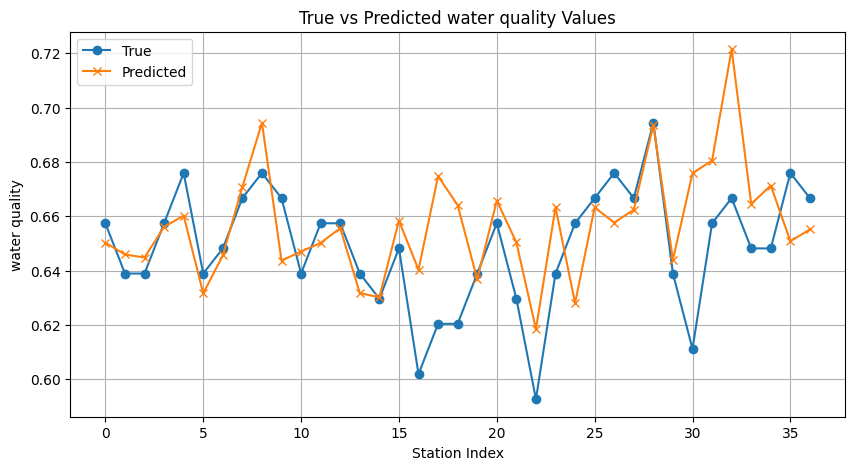

In [188]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    # Get one batch from the test loader
    sample_x, sample_y =  random.choice(list(test_loader))
    sample_x = sample_x.to(device)
    sample_y = sample_y.to(device)
    
    # Get predictions from the model
    predictions = model(sample_x)
    
    # Move tensors to CPU and convert to numpy arrays for easier handling
    predictions_np = predictions.cpu().numpy()
    true_np = sample_y.cpu().numpy()

# Print true and predicted outputs for the first sample in the batch
print("Comparison for the first sample in the batch:")
for station_idx in range(true_np.shape[1]):
    true_val = true_np[0, station_idx]
    pred_val = predictions_np[0, station_idx]
    print(f"Station {station_idx+1:2d}: True = {true_val:.4f}, Predicted = {pred_val:.4f}")

# Optionally, plot the true vs. predicted pH values for the first sample
plt.figure(figsize=(10, 5))
plt.plot(true_np[0], label="True", marker='o')
plt.plot(predictions_np[0], label="Predicted", marker='x')
plt.title("True vs Predicted water quality Values")
plt.xlabel("Station Index")
plt.ylabel("water quality")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
6

6